In [250]:
import pandas as pd

urlstops = 'https://raw.githubusercontent.com/dustinhodges/DS-Unit-2-Applied-Modeling/master/MplsStops.csv'
urldemo = 'https://raw.githubusercontent.com/dustinhodges/DS-Unit-2-Applied-Modeling/master/MplsDemo.csv'

stops = pd.read_csv(urlstops)
stops.shape

(51920, 15)

In [251]:
stops.head()

,Unnamed: 0,idNum,date,problem,MDC,citationIssued,personSearch,vehicleSearch,preRace,race,gender,lat,long,policePrecinct,neighborhood
0,6823,17-000003,2017-01-01 00:00:42,suspicious,MDC,NaN,NO,NO,Unknown,Unknown,Unknown,44.966617,-93.246458,1,Cedar Riverside
1,6824,17-000007,2017-01-01 00:03:07,suspicious,MDC,NaN,NO,NO,Unknown,Unknown,Male,44.980450,-93.271340,1,Downtown West
2,6825,17-000073,2017-01-01 00:23:15,traffic,MDC,NaN,NO,NO,Unknown,White,Female,44.948350,-93.275380,5,Whittier
3,6826,17-000092,2017-01-01 00:33:48,suspicious,MDC,NaN,NO,NO,Unknown,East African,Male,44.948360,-93.281350,5,Whittier
4,6827,17-000098,2017-01-01 00:37:58,traffic,MDC,NaN,NO,NO,Unknown,White,Female,44.979078,-93.262076,1,Downtown West


In [252]:
demo = pd.read_csv(urldemo)
demo.head()

,Unnamed: 0,neighborhood,population,white,black,foreignBorn,hhIncome,poverty,collegeGrad
0,1,Cedar Riverside,8247,0.353,0.464,0.408,18892,0.060,0.258
1,3,Phillips West,5184,0.199,0.538,0.318,18404,0.042,0.211
2,4,Downtown West,7141,0.561,0.211,0.203,67086,0.057,0.551
3,5,Downtown East,1674,0.543,0.221,0.221,70669,0.071,0.577
4,6,Shingle Creek,3249,0.407,0.259,0.140,59414,0.110,0.247


In [253]:
minn = pd.merge(stops, demo, how='outer', on='neighborhood')

print(minn.shape)
minn.head()

(51920, 23)


,Unnamed: 0_x,idNum,date,problem,MDC,citationIssued,personSearch,vehicleSearch,preRace,race,...,policePrecinct,neighborhood,Unnamed: 0_y,population,white,black,foreignBorn,hhIncome,poverty,collegeGrad
0,6823,17-000003,2017-01-01 00:00:42,suspicious,MDC,NaN,NO,NO,Unknown,Unknown,...,1,Cedar Riverside,1.0,8247.0,0.353,0.464,0.408,18892.0,0.06,0.258
1,6834,17-000161,2017-01-01 01:15:01,traffic,other,NaN,NaN,NaN,NaN,NaN,...,1,Cedar Riverside,1.0,8247.0,0.353,0.464,0.408,18892.0,0.06,0.258
2,6909,17-001251,2017-01-01 23:45:15,traffic,other,NaN,NaN,NaN,NaN,NaN,...,1,Cedar Riverside,1.0,8247.0,0.353,0.464,0.408,18892.0,0.06,0.258
3,6992,17-002190,2017-01-02 21:46:12,suspicious,MDC,NaN,NO,NO,White,White,...,1,Cedar Riverside,1.0,8247.0,0.353,0.464,0.408,18892.0,0.06,0.258
4,7134,17-003851,2017-01-04 09:06:24,traffic,other,NaN,NaN,NaN,NaN,NaN,...,1,Cedar Riverside,1.0,8247.0,0.353,0.464,0.408,18892.0,0.06,0.258


[ ] Choose your target. Which column in your tabular dataset will you predict?

'outcome', a newly engineered column will be our target. First we will clean three other columns in order to combine them:

In [254]:
minn['citationIssued'].value_counts()

NO     15899
YES     3211
Name: citationIssued, dtype: int64

In [255]:
minn['personSearch'].value_counts()

NO     38462
YES     5237
Name: personSearch, dtype: int64

In [256]:
minn['vehicleSearch'].value_counts()

NO     40579
YES     3120
Name: vehicleSearch, dtype: int64

In [257]:
minn[['citationIssued', 'personSearch', 'vehicleSearch']] = minn[['citationIssued', 'personSearch', 'vehicleSearch']].fillna('Unknown')


In [258]:
minn.head()

,Unnamed: 0_x,idNum,date,problem,MDC,citationIssued,personSearch,vehicleSearch,preRace,race,...,policePrecinct,neighborhood,Unnamed: 0_y,population,white,black,foreignBorn,hhIncome,poverty,collegeGrad
0,6823,17-000003,2017-01-01 00:00:42,suspicious,MDC,Unknown,NO,NO,Unknown,Unknown,...,1,Cedar Riverside,1.0,8247.0,0.353,0.464,0.408,18892.0,0.06,0.258
1,6834,17-000161,2017-01-01 01:15:01,traffic,other,Unknown,Unknown,Unknown,NaN,NaN,...,1,Cedar Riverside,1.0,8247.0,0.353,0.464,0.408,18892.0,0.06,0.258
2,6909,17-001251,2017-01-01 23:45:15,traffic,other,Unknown,Unknown,Unknown,NaN,NaN,...,1,Cedar Riverside,1.0,8247.0,0.353,0.464,0.408,18892.0,0.06,0.258
3,6992,17-002190,2017-01-02 21:46:12,suspicious,MDC,Unknown,NO,NO,White,White,...,1,Cedar Riverside,1.0,8247.0,0.353,0.464,0.408,18892.0,0.06,0.258
4,7134,17-003851,2017-01-04 09:06:24,traffic,other,Unknown,Unknown,Unknown,NaN,NaN,...,1,Cedar Riverside,1.0,8247.0,0.353,0.464,0.408,18892.0,0.06,0.258


In [259]:
end = minn['citationIssued'] + minn['personSearch'] + minn['vehicleSearch']
minn['outcome'] = end

minn['outcome'].value_counts()

UnknownNONO              21406
NONONO                   13805
UnknownUnknownUnknown     8221
YESNONO                   2662
UnknownYESYES             1452
UnknownYESNO              1422
NOYESNO                   1076
NOYESYES                   828
UnknownNOYES               309
YESYESYES                  251
YESYESNO                   208
NONOYES                    190
YESNOYES                    90
Name: outcome, dtype: int64

[ ] Is your problem regression or classification?

Classification. Now we will define and refine our classes:

In [260]:
minn.outcome = minn.outcome.replace({"UnknownNONO": "none",
                                     "NONONO": "none",
                                     "UnknownUnknownUnknown": "unknown",
                                     "YESNONO": "citation",
                                     "UnknownYESYES": "search",
                                     "UnknownYESNO": "search",
                                     "NOYESNO": "search",
                                     "NOYESYES": "search",
                                     "UnknownNOYES": "search",
                                     "YESYESYES": "search + citation",
                                     "YESYESNO": "search + citation",
                                     "NONOYES": "search",
                                     "YESNOYES": "search + citation"}
                                   ) 

minn['outcome'].value_counts()

none                 35211
unknown               8221
search                5277
citation              2662
search + citation      549
Name: outcome, dtype: int64

In [261]:
none = 35211
unknown = 8221
search = 5277
citation = 2662
both = 549
total = none + unknown + search + citation + both
total

51920

In [262]:
none / total

0.6781779661016949

In [263]:
both / total

0.010573959938366718

[ ] How is your target distributed?
Classification: How many classes? Are the classes imbalanced?
Regression: Is the target right-skewed? If so, you may want to log transform the target.

'outcome' has 5 discrete classes: 
none, unknown, search, citation, search + citation.

'none' occurs 68% of the time. 'search + citation' occurs 1% of the time.

In [264]:
minn['race'].value_counts()

Black              15220
White              11703
Unknown             9219
East African        2188
Latino              1858
Native American     1516
Other               1348
Asian                647
Name: race, dtype: int64

In [265]:
minn['problem'].value_counts()

traffic       26098
suspicious    25822
Name: problem, dtype: int64

[ ] Choose which observations you will use to train, validate, and test your model.
Are some observations outliers? Will you exclude them?
Will you do a random split or a time-based split?

There are no 'outliers' in this case with the possible exception of 'unknown' values where presumably the data was not recorded by police officers. We will not exclude them because we want our app to handle incomplete input information.
I will use a random split for train, test, validation.

[ ] Choose your evaluation metric(s).
Classification: Is your majority class frequency > 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?

I can use accuracy but I'll also want to explore precision and recall for certain classes. For example, predicting a particular outcome for a particular demographic etc could be "false alarm" or "failure to warn". Must decide which is worse...

In [266]:
print(minn.shape)
minn.tail()

(51920, 24)


,Unnamed: 0_x,idNum,date,problem,MDC,citationIssued,personSearch,vehicleSearch,preRace,race,...,neighborhood,Unnamed: 0_y,population,white,black,foreignBorn,hhIncome,poverty,collegeGrad,outcome
51915,52565,17-409788,2017-10-24 02:58:15,suspicious,MDC,NO,NO,NO,Unknown,Black,...,Camden Industrial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none
51916,53479,17-418924,2017-10-30 23:17:31,traffic,MDC,NO,NO,NO,Unknown,White,...,Camden Industrial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none
51917,53549,17-419685,2017-10-31 15:49:53,traffic,MDC,Unknown,NO,NO,Unknown,Black,...,Camden Industrial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none
51918,56559,17-449934,2017-11-25 16:39:48,traffic,MDC,NO,NO,NO,Unknown,Black,...,Camden Industrial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none
51919,60446,17-487296,2017-12-28 01:17:45,suspicious,MDC,NO,NO,NO,Unknown,White,...,Camden Industrial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none


[ ] Begin to clean and explore your data.

In [267]:
minn['preRace'].isnull().value_counts()

False    43699
True      8221
Name: preRace, dtype: int64

In [268]:
minn['race'].isnull().value_counts()

False    43699
True      8221
Name: race, dtype: int64

In [269]:
minn['preRace'].value_counts()

Unknown            28337
Black               6805
White               6004
Native American      908
Latino               528
Other                484
East African         481
Asian                152
Name: preRace, dtype: int64

In [270]:
minn['race'].value_counts()

Black              15220
White              11703
Unknown             9219
East African        2188
Latino              1858
Native American     1516
Other               1348
Asian                647
Name: race, dtype: int64

visualizations, 

[ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

In [271]:
import numpy as np
from sklearn.model_selection import train_test_split

train = minn.copy()
train, test = train_test_split(train, train_size=0.80, test_size=0.20,
                               stratify=train['outcome'], random_state=42)
train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                             stratify=train['outcome'], random_state=42)

train.shape, val.shape, test.shape

((33228, 24), (8308, 24), (10384, 24))

In [272]:
train['date'].dtype

dtype('O')

In [273]:
minn.columns

Index(['Unnamed: 0_x', 'idNum', 'date', 'problem', 'MDC', 'citationIssued',
       'personSearch', 'vehicleSearch', 'preRace', 'race', 'gender', 'lat',
       'long', 'policePrecinct', 'neighborhood', 'Unnamed: 0_y', 'population',
       'white', 'black', 'foreignBorn', 'hhIncome', 'poverty', 'collegeGrad',
       'outcome'],
      dtype='object')

In [274]:
def wrangle(X):
    
    X = X.copy()
    
    X[['race_MISSING']] = X[['race']].isnull()
    X[['gender_MISSING']] = X[['gender']].isnull()

    unusable_variance = ['Unnamed: 0_x', 'idNum','citationIssued',
                         'personSearch', 'vehicleSearch', 'Unnamed: 0_y']
    X = X.drop(columns=unusable_variance)
    
    X['date'] = pd.to_datetime(X['date'], infer_datetime_format=True)
    
    X['month'] = X['date'].dt.month
    X['day'] = X['date'].dt.day
    X['hour'] = X['date'].dt.hour
    X = X.drop(columns='date')
    
    X['race_confusion'] = (X['race'] != X['preRace'])
    
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)


engineer:

race of neighborhood, demographics etc...
racialconfusion,

string encode policePrecinct


In [297]:
train.shape

(33228, 23)

In [298]:
train.head()

,problem,MDC,preRace,race,gender,lat,long,policePrecinct,neighborhood,population,...,hhIncome,poverty,collegeGrad,outcome,race_MISSING,gender_MISSING,month,day,hour,race_confusion
33578,traffic,MDC,Unknown,White,Male,44.991982,-93.217693,2,Mid - City Industrial,240.0,...,38875.0,0.067,0.568,none,False,False,9,1,22,True
50084,traffic,MDC,White,White,Female,44.905100,-93.295294,5,Lynnhurst,5934.0,...,118202.0,0.031,0.763,none,False,False,3,2,13,False
4992,suspicious,MDC,Unknown,Native American,Male,44.978210,-93.269290,1,Downtown West,7141.0,...,67086.0,0.057,0.551,none,False,False,12,5,11,True
37555,traffic,MDC,Unknown,White,Unknown,44.992669,-93.237184,2,Como,16022.0,...,67600.0,0.037,0.549,none,False,False,1,24,10,True
16288,suspicious,MDC,Unknown,Unknown,Male,44.956435,-93.294405,5,Lowry Hill East,6357.0,...,49868.0,0.066,0.569,none,False,False,7,31,13,False


In [299]:
target = 'outcome'

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [333]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline

pipeline1 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8375060182956187


Fit a model. Does it beat your baseline?

Our baseline is 68% 
With minimal feature engineering 
and basic RandomForestClassifier model, 
we're up to 81%. A good Start!
With date features, racial confusion, up to 84%

Unit 2, Sprint 3, Module 2
Permutation & Boosting

 
Continue to clean and explore your data. Make exploratory visualizations.
Complete Engineering with initial ideas. 

Try xgboost.
Get your model's permutation importances.



In [301]:
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [302]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [303]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_,
         feature_names).sort_values(ascending=False)

month             0.013385
problem           0.009076
hour              0.005513
day               0.001757
lat               0.000867
gender            0.000578
MDC               0.000506
collegeGrad       0.000361
race             -0.000048
race_MISSING     -0.000072
gender_MISSING   -0.000169
hhIncome         -0.000193
long             -0.000265
foreignBorn      -0.000626
poverty          -0.000843
policePrecinct   -0.000915
preRace          -0.001396
population       -0.001468
race_confusion   -0.001541
white            -0.001709
neighborhood     -0.001805
black            -0.002022
dtype: float64

In [304]:
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.0134 ± 0.0027,month
0.0091 ± 0.0022,problem
0.0055 ± 0.0027,hour
0.0018 ± 0.0026,day
0.0009 ± 0.0032,lat
0.0006 ± 0.0038,gender
0.0005 ± 0.0004,MDC
0.0004 ± 0.0018,collegeGrad
-0.0000 ± 0.0030,race
-0.0001 ± 0.0007,race_MISSING


In [305]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (33228, 22)


In [306]:
minimum_importance = -0.0003
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

In [307]:
print('Shape after removing features:', X_train.shape)

Shape after removing features: (33228, 13)


In [308]:
X_val = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8396726047183438


removing features slightly lowered our validation

In [309]:
train['MDC'].value_counts()

MDC      27967
other     5261
Name: MDC, dtype: int64

In [314]:
from xgboost import XGBClassifier

xgb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['problem', 'MDC', 'race', 'gender'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'problem',
                                          'data_type': dtype('O'),
                                          'mapping': traffic       1
suspicious    2
NaN          -2
dtype: int64},
                                         {'col': 'MDC', 'data_type': dtype('O'),
                                          'mapping': MDC      1
other    2
NaN     -2
dtype: int64},
                                         {'col': 'race'...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max

In [315]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8375060182956187


In [312]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators=1000,
    max_depth=7,
    learning_rate=0.5,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train),
           (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train,
         eval_set=eval_set,
         eval_metric='merror',
         early_stopping_rounds=50)

[0]	validation_0-merror:0.15821	validation_1-merror:0.163216
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.158391	validation_1-merror:0.161892
[2]	validation_0-merror:0.157277	validation_1-merror:0.16105
[3]	validation_0-merror:0.156765	validation_1-merror:0.16117
[4]	validation_0-merror:0.156434	validation_1-merror:0.16105
[5]	validation_0-merror:0.155441	validation_1-merror:0.161651
[6]	validation_0-merror:0.15511	validation_1-merror:0.161651
[7]	validation_0-merror:0.154538	validation_1-merror:0.161531
[8]	validation_0-merror:0.153184	validation_1-merror:0.161892
[9]	validation_0-merror:0.152462	validation_1-merror:0.162374
[10]	validation_0-merror:0.151679	validation_1-merror:0.161411
[11]	validation_0-merror:0.150114	validation_1-merror:0.161411
[12]	validation_0-merror:0.149874	validation_1-merror:0.16105
[13]	validation_0-merror:0.148459	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

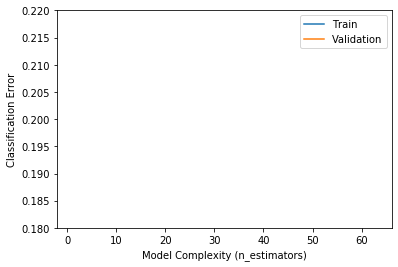

In [294]:
import matplotlib.pyplot as plt

results = model.evals_result()
train_error = results['validation_0']['merror']
val_error = results['validation_1']['merror']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.18, 0.22)) # Zoom in
plt.legend();

Assignment
Complete these tasks for your project, and document your work.

[ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
[ ] Make at least 1 partial dependence plot to explain your model.
[ ] Share at least 1 visualization on Slack.
(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

Stretch Goals
[ ] Make multiple PDPs with 1 feature in isolation.
[ ] Make multiple PDPs with 2 features in interaction.
[ ] Use Plotly to make a 3D PDP.
[ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

In [326]:
from pdpbox.pdp import pdp_interact, pdp_isolate, pdp_interact_plot

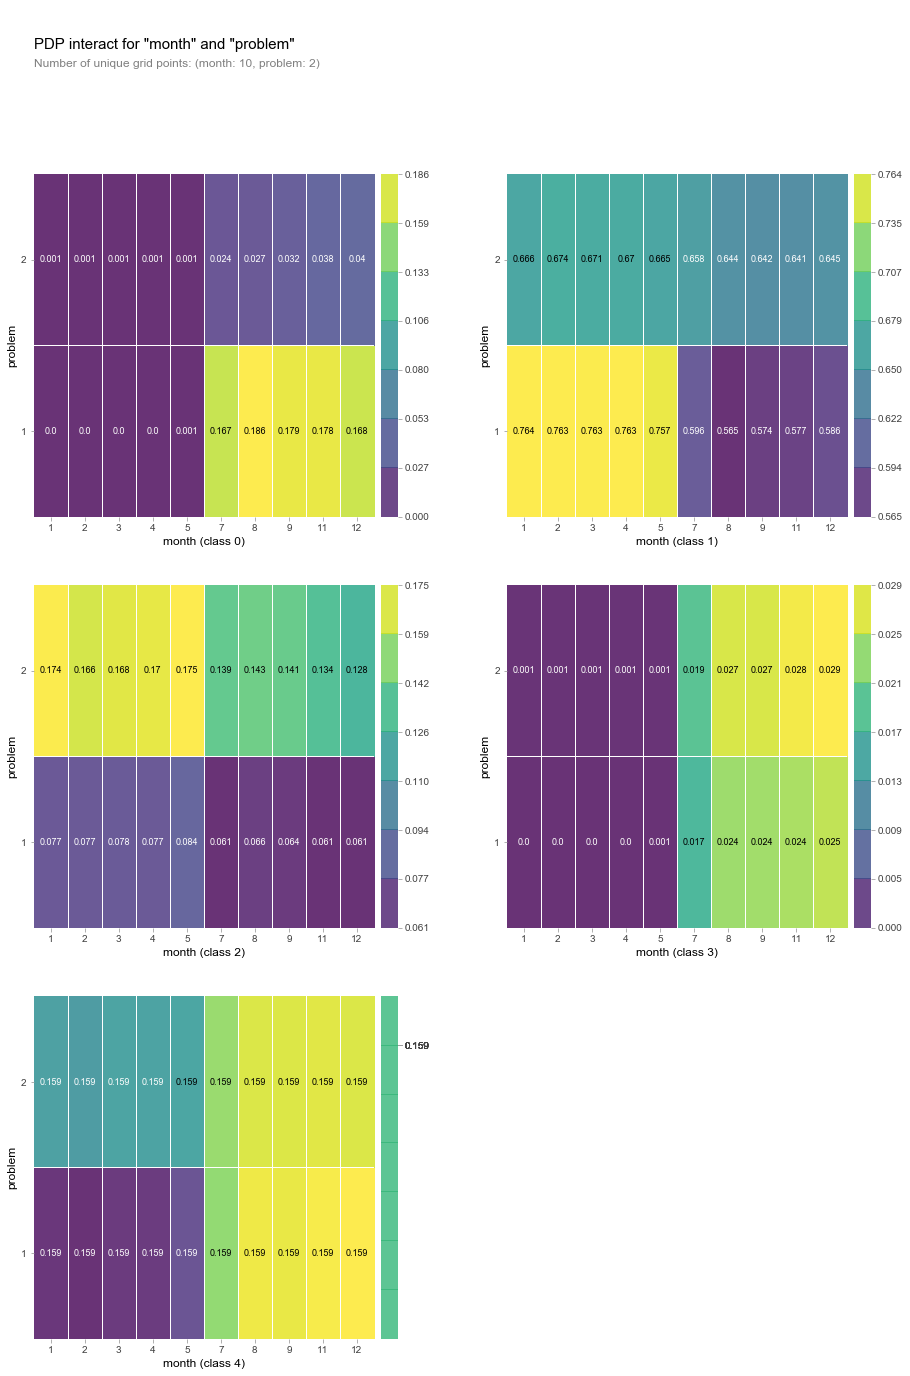

In [337]:
features = ['month', 'problem']

interaction = pdp_interact(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

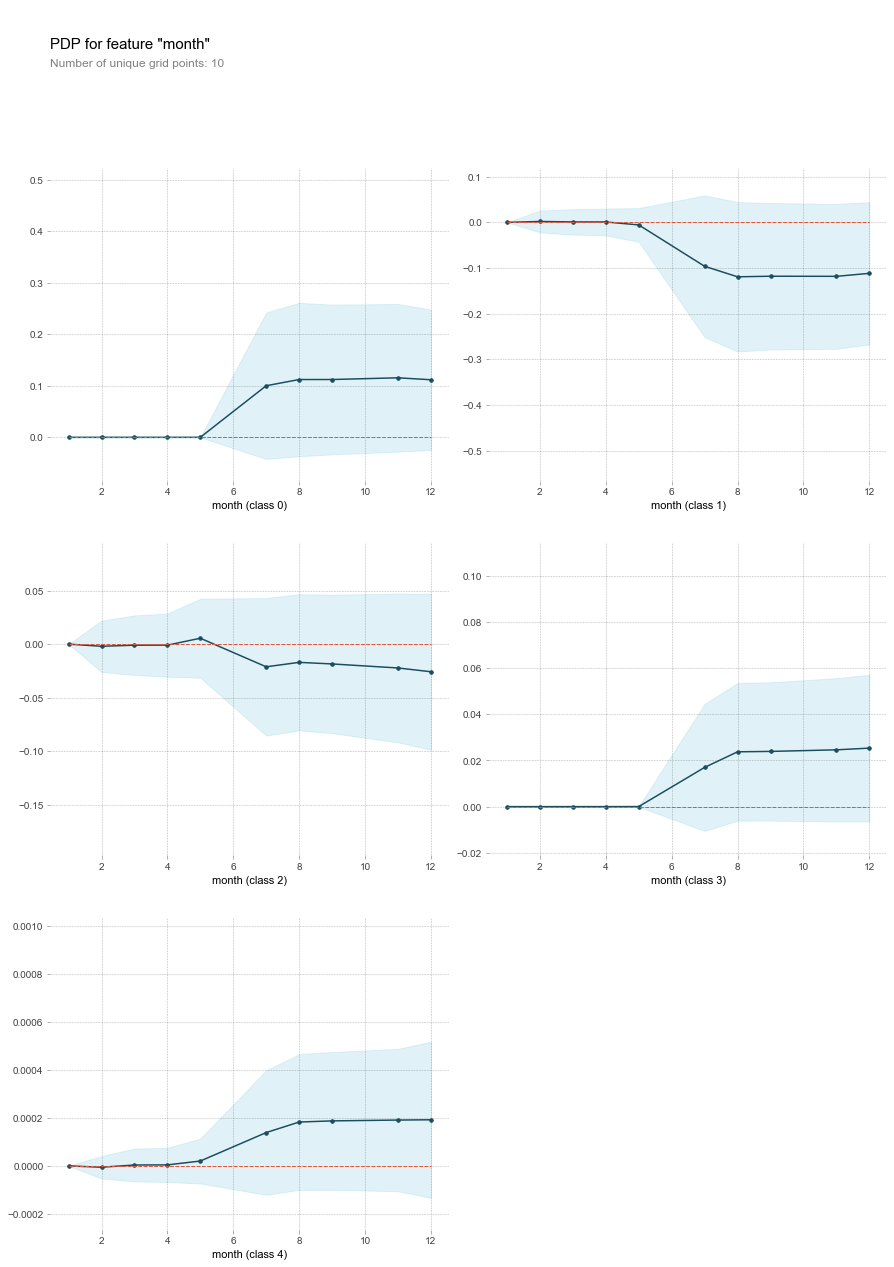

In [336]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'month'

isolated = pdp_isolate(
    model=model,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

In [332]:
train.head()

,problem,MDC,preRace,race,gender,lat,long,policePrecinct,neighborhood,population,...,hhIncome,poverty,collegeGrad,outcome,race_MISSING,gender_MISSING,month,day,hour,race_confusion
33578,traffic,MDC,Unknown,White,Male,44.991982,-93.217693,2,Mid - City Industrial,240.0,...,38875.0,0.067,0.568,none,False,False,9,1,22,True
50084,traffic,MDC,White,White,Female,44.905100,-93.295294,5,Lynnhurst,5934.0,...,118202.0,0.031,0.763,none,False,False,3,2,13,False
4992,suspicious,MDC,Unknown,Native American,Male,44.978210,-93.269290,1,Downtown West,7141.0,...,67086.0,0.057,0.551,none,False,False,12,5,11,True
37555,traffic,MDC,Unknown,White,Unknown,44.992669,-93.237184,2,Como,16022.0,...,67600.0,0.037,0.549,none,False,False,1,24,10,True
16288,suspicious,MDC,Unknown,Unknown,Male,44.956435,-93.294405,5,Lowry Hill East,6357.0,...,49868.0,0.066,0.569,none,False,False,7,31,13,False
